# Generating Data
Like in my post on [building neural networks from scratch](https://beckernick.github.io/neural-network-scratch/), I'm going to use simulated data. I can easily simulate separable data by sampling from a multivariate normal distribution.

In [1]:
import numpy as np
import nodepy 
import matplotlib.pyplot as plt
import sys
import scipy as sp
from scipy import io
%matplotlib inline

np.random.seed(12)
num_observations = 3
clusters = 1
dim = 10
spread = 10
margin = np.random.randint(10, size=dim) * 50

for i in range(clusters):
    if i == 0:
        x1 = np.random.multivariate_normal(np.random.randint(spread, size=dim) + margin, np.identity(dim), num_observations)
        x2 = np.random.multivariate_normal(np.random.randint(spread, size=dim), np.identity(dim), num_observations)
    else:
        x1 = np.append(x1, np.random.multivariate_normal(np.random.randint(spread, size=dim) + margin, np.identity(dim), num_observations), axis=0)
        x2 = np.append(x2, np.random.multivariate_normal(np.random.randint(spread, size=dim), np.identity(dim), num_observations), axis=0)

simulated_separableish_features = np.vstack((x1, x2)).astype(np.float32)
simulated_labels = np.hstack((np.zeros(len(x1)),
                              np.ones(len(x2))))
intercept = np.ones((simulated_separableish_features.shape[0], 1))
simulated_separableish_features = np.hstack((intercept, simulated_separableish_features))
dim += 1

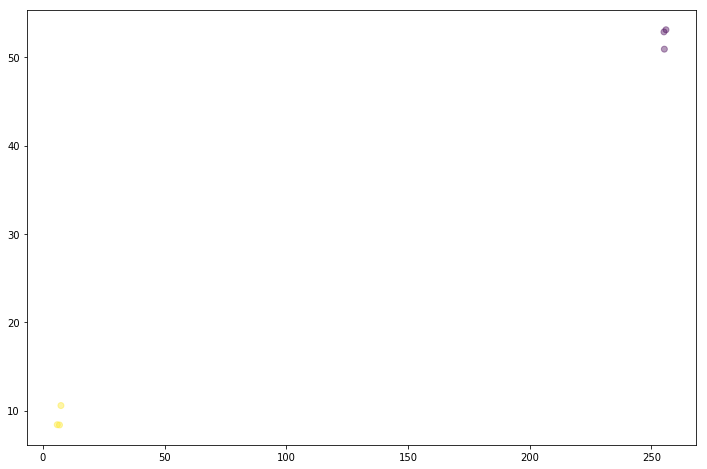

In [2]:
plt.figure(figsize=(12,8))
plt.scatter(simulated_separableish_features[:, -1], simulated_separableish_features[:, 2],
            c = simulated_labels, alpha = .4)

# 4th

In [3]:
def sigmoid(scores):
    return 1 / (1 + np.exp(-scores))

In [64]:
K=4
def grad_logistic(X, Y, w):
    pred = np.dot(X, w) - Y
    return np.dot( np.power(pred, K-1).T, X)

def loss_logistic(X, Y, w):
    pred = Y - np.dot(X, w)
    return (1/K) * np.sum(np.power(pred, K))


## Show that GD works

In [120]:
def gd(f, df, num_steps, learning_rate, inits, period=5000):
    losses = np.zeros(int(num_steps/period))
    weights = inits
    for step in xrange(num_steps):
        # Update weights with log likelihood gradient
        gradient = - df(weights)
        #gradient = np.dot(features.T, output_error_signal)
        weights += learning_rate * gradient
        # Print log-likelihood every so often
        if step % period == 0:
            losses[int(step/period)] = f(weights)
        if step % (num_steps/5) == 0:
            print losses[int(step/period)]
        
    return weights, losses

In [121]:
weights = np.zeros(dim)
f = lambda x: loss_logistic(simulated_separableish_features, simulated_labels, x)
df = lambda x: grad_logistic(simulated_separableish_features, simulated_labels, x)
weights, losses = gd(f, df, num_steps = int(1e6), learning_rate = 3e-6, 
                     inits=weights, period=1)

0.7425337947890062
5.959309978713803e-05
4.742874092444156e-05
3.923438601744773e-05
3.337676443290331e-05


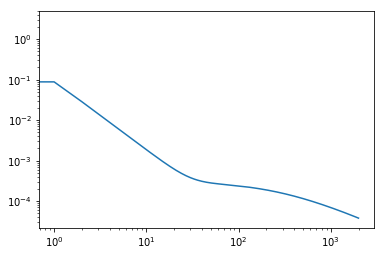

In [7]:
plt.loglog(losses[:])

In [311]:
def gd_(f, df, num_steps, learning_rate, inits, period=5000):
    losses = np.zeros(int(num_steps/period))
    weights = inits
    for step in xrange(num_steps):
        # Update weights with log likelihood gradient
        gradient = - df(weights)
        #gradient = np.dot(features.T, output_error_signal)
        weights += learning_rate * gradient
        # Print log-likelihood every so often
        if step % period == 0:
            losses[int(step/period)] = f(weights)
        if step % (num_steps/5) == 0:
            print losses[int(step/period)]
        
    return weights, losses

In [312]:
print(losses[-1])

1.1272651963670222e-05


In [10]:
def nag(f, df, num_steps, learning_rate, inits, period=5000):
    losses = np.zeros(int(num_steps/period))
    x = inits
    x_prev = inits
    y = inits
    for k in xrange(num_steps):
        # Update weights with log likelihood gradient
        x, x_prev = y - learning_rate * df(y), x
        y = x + (k-1.0)/(k+2.0)*(x-x_prev)

        # Print log-likelihood every so often
        if k % period == 0:
            losses[int(k/period)] = f(x)
        if k % (num_steps/10) == 0:
            print losses[int(k/period)]
        
    return x, losses

In [71]:
weights = np.zeros(dim)
f = lambda x: loss_logistic(simulated_separableish_features, simulated_labels, x)
df = lambda x: grad_logistic(simulated_separableish_features, simulated_labels, x)
weights, losses = nag(f, df, num_steps = int(1e6), learning_rate = 1e-6, 
                     inits=weights, period=1)

0.747501297106557
3.534684115448508e-09
6.014016345892642e-11
7.2131354774538554e-12
2.5726005191491335e-12
6.913590484281296e-13
1.912295553060629e-13
9.560126142798377e-14
7.216765650728732e-14
5.817802216041853e-14


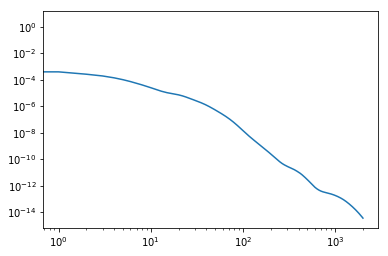

In [12]:
plt.loglog(losses[:])

In [72]:
def rgd(f, df, num_steps, learning_rate, inits, period):
    losses = np.zeros(int(num_steps/period))
    weights = inits
    for step in range(num_steps):
        # Update weights with log likelihood gradient
        gradient = - df(weights)
        #gradient = np.dot(features.T, output_error_signal)
        weights += learning_rate * gradient/(np.power(np.linalg.norm(gradient),2/3)) 
        # Print log-likelihood every so often
        if step % period == 0:
            losses[int(step/period)] = f(weights)
        if step % (num_steps/5) == 0:
            print(losses[int(step/period)])
        
    return weights, losses

0.7204039451345083
2.9004376153816234e-05
1.7407495606852867e-05
1.2374876000742136e-05
9.5470359225392e-06
7.718163085482188e-06


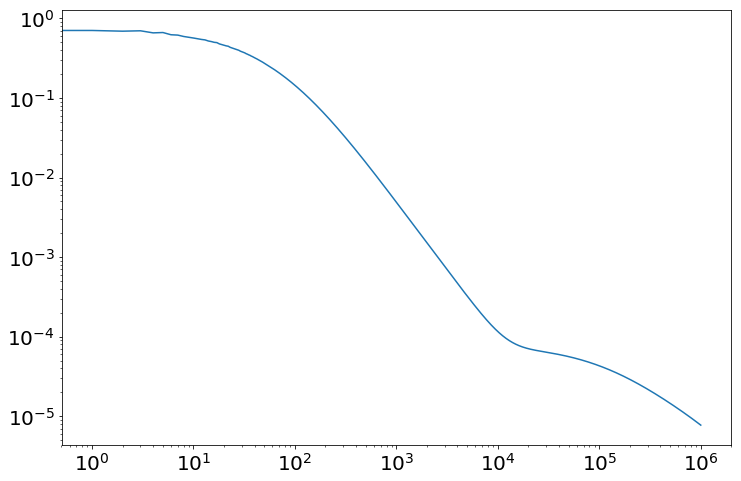

In [319]:
N = int(1e6)
truncate = 0
period = 1
nrange = period * np.arange(int(N/period))- period + 1
plt.figure(figsize = (12, 8))


weights = np.zeros(dim)
f = lambda x: loss_logistic(simulated_separableish_features, simulated_labels, x)
df = lambda x: grad_logistic(simulated_separableish_features, simulated_labels, x)
weights, losses = rgd(f, df, num_steps = N, learning_rate = 1.5e-5, 
                     inits=weights, period=period)
plt.loglog(nrange, losses[truncate:], label='RGD')

print(losses[-1])



In [155]:
## ARGD IMPLEMENTATION

In [344]:
def argd(f, df, num_steps, learning_rate, inits, period):
    losses = np.zeros(int(num_steps/period))
    x = inits
    x_prev = inits
    y = inits
    for k in xrange(num_steps):
        # Update weights with log likelihood gradient
        x, x_prev = y - learning_rate * df(y)/(np.power(np.linalg.norm(df(y))+1e-5,2/3)), x
        y = x + (k-1)/(k+4.0)*(x-x_prev) - np.power(learning_rate,3)*(k+1)*(k+2)*(k+3)*df(y)/(np.power(np.linalg.norm(df(y))+1e-5,2/3))
        # Print log-likelihood every so often
        if k % period == 0:
            losses[int(k/period)] = f(x)
        if k % (num_steps/10) == 0:
            print losses[int(k/period)]
    return x, losses

0.7267208408033181
9.249668780829596e-19
5.720151164944926e-21
2.762750433090772e-22
5.6183722887573025e-24
2.5430222126526884e-25
4.742991395254423e-25
7.623946041190879e-26
1.7597312831868754e-26
9.548125663852047e-27
8.382963406456005e-28


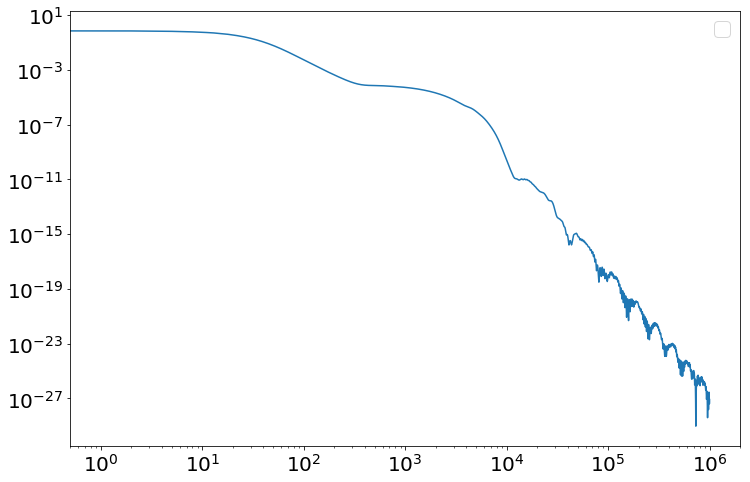

In [346]:
N = int(1e6)
truncate = 0
period = 1
nrange = period * np.arange(int(N/period))- period + 1
plt.figure(figsize = (12, 8))
plt.legend()

weights = np.zeros(dim)
f = lambda x: loss_logistic(simulated_separableish_features, simulated_labels, x)
df = lambda x: grad_logistic(simulated_separableish_features, simulated_labels, x)
weights, losses = argd(f, df, num_steps = N, learning_rate = 1e-5, 
                     inits=weights, period=period)
plt.loglog(nrange, losses[truncate:], label='ARGD')

print(losses[-1])

# Simulate ODE flow

In [13]:

import nodepy.runge_kutta_method as rk
import nodepy.convergence as cv
from nodepy import ivp

class ODE_IVP(nodepy.ivp.IVP):
    
    def __init__(self, X, Y, p, u0, t0=0., T=1000000., desc='', name=''):
        
        #intercept = np.ones((X.shape[0], 1))
        #self.X = np.hstack((intercept, X))
        self.Y = Y
        self.X = X
        self.p = float(p)
        self.u0  = u0
        self.dim = len(u0)/2
        self.rhs = self.dynamics
        self.T   = T
        self.exact = None
        self.description = desc
        self.t0 = t0
        self.name = name
    
    def dynamics(self, t, u):
        x = u[:self.dim]
        v = u[self.dim:]
        p = self.p
        dv = - (p+1) / (t) * v - p**2 * t**(p-2) * grad_logistic(self.X, self.Y, x)
        return np.append(v, dv)
    
    

In [14]:
# Same integrator on different ODE

def simulate(p, s, N, period, step, inits):
    h = step
    if s==1:
        name = 'FE'
    elif s==2:
        name = 'SSP22'
    elif s==4:
        name = 'RK44'
    elif s==8:
        name = 'PD8'
    else:
        return None
    u = [inits]
    integrator =rk.loadRKM(name)
    loop = N/period
    losses = np.zeros(int(N/period))
    ode_ivp = ODE_IVP(simulated_separableish_features, simulated_labels, p, u0=u[-1])
    for j in range(loop):
        losses[j] = loss_logistic(simulated_separableish_features, simulated_labels, u[-1][:dim])
        if np.isnan(losses[j]) or np.isinf(losses[j]):
            losses[j]=1e4
        t,u = integrator(ode_ivp, t0= 0.1 + j * period * h, dt=h, max_steps=period)
        ode_ivp = ODE_IVP(simulated_separableish_features, simulated_labels, p, u0=u[-1])
    return losses



In [15]:
N = int(1e4)
truncate = 0
period = 500
pvalues = [1,2,4]
nrange = period * np.arange(int(N/period)) - period + 1

/Users/ashia/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in power
  after removing the cwd from sys.path.
/Users/ashia/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in subtract
/Users/ashia/anaconda2/lib/python2.7/site-packages/nodepy/runge_kutta_method.py:1444: RuntimeWarning: invalid value encountered in multiply
  y[i] += self.alpha[i,j]*y[j] + dt*self.beta[i,j]*fy[j]


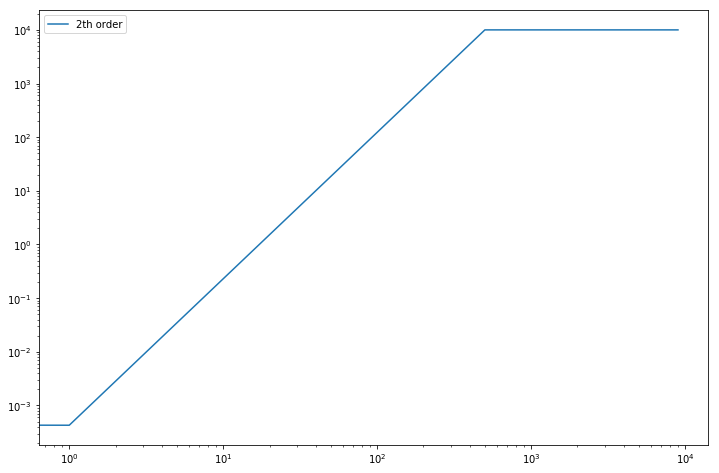

In [16]:
plt.figure(figsize = (12, 8))
losses = simulate(8, 2, N, period, 1e-3,np.zeros(dim * 2))
plt.loglog(nrange, losses[truncate:], label=str(2) + 'th order')
plt.legend()

In [17]:
np.isnan(losses[3])

False

2.960314772987377
0.0002197478034086471
0.00016659320812169613
0.00013350850253803181
0.00011112220197496533
2.960314772987377
2.406542419549005e-10
1.0283887013702989e-11
7.660275543206838e-13
2.893386899180653e-13
1.7976848049894932e-13
9.567808284762724e-14
4.4117492233159954e-14
1.9310617892675112e-14
8.261124863748126e-15


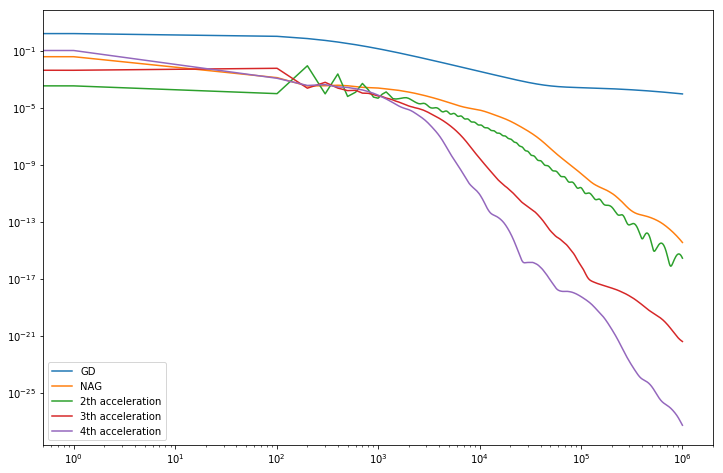

In [18]:
N = int(1e6)
truncate = 0
period = 100
pvalues = [1,2,4]
nrange = period * np.arange(int(N/period))- period + 1

svals = [4, 4, 4]
pvals = [2, 3, 4]
steps = [1e-3, 1e-3, 1e-3]
plt.figure(figsize = (12, 8))


f = lambda x: loss_logistic(simulated_separableish_features, simulated_labels, x)
df = lambda x: grad_logistic(simulated_separableish_features, simulated_labels, x)

weights = np.zeros(dim)
_, losses = gd(f, df, num_steps = N, learning_rate = 1e-6, 
                     inits=weights, period=period)

weights = np.zeros(dim)
plt.loglog(nrange, losses[truncate:], label='GD')
_, losses = nag(f, df, num_steps = N, learning_rate = 1e-6, 
                     inits=weights, period=period)
plt.loglog(nrange, losses[truncate:], label='NAG')


for i, s in enumerate(svals):
    losses = simulate(pvals[i], s, N, period, steps[i], np.zeros(dim * 2))
    plt.loglog(nrange, losses[truncate:], label=str(pvals[i]) + 'th acceleration')
plt.legend()

2.960314772987377
5.481196640240972e-05
2.8967905334204826e-05
1.897937184419143e-05
1.3898483458500394e-05
2.960314772987377
3.476236666012134e-15
1.568285538604291e-16
7.75773826077078e-17
2.377245182635014e-17
8.151770818516263e-18
2.8169139574402925e-18
4.922490535350413e-18
8.30072050555883e-18
2.277989421447403e-17


KeyboardInterrupt: 

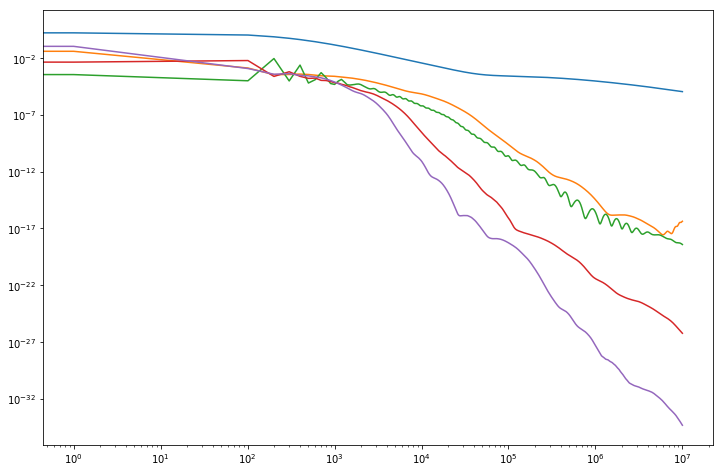

In [19]:
N = int(1e7)
truncate = 0
period = 100
pvalues = [1,2,4]
nrange = period * np.arange(int(N/period))- period + 1

svals = [4, 4, 4, 4]
pvals = [2, 3, 4, 5]
steps = [1e-3, 1e-3, 1e-3, 1e-3]
plt.figure(figsize = (12, 8))


f = lambda x: loss_logistic(simulated_separableish_features, simulated_labels, x)
df = lambda x: grad_logistic(simulated_separableish_features, simulated_labels, x)

weights = np.zeros(dim)
_, losses = gd(f, df, num_steps = N, learning_rate = 1e-6, 
                     inits=weights, period=period)

weights = np.zeros(dim)
plt.loglog(nrange, losses[truncate:], label='GD')
_, losses = nag(f, df, num_steps = N, learning_rate = 1e-6, 
                     inits=weights, period=period)
plt.loglog(nrange, losses[truncate:], label='NAG')


for i, s in enumerate(svals):
    losses = simulate(pvals[i], s, N, period, steps[i], np.zeros(dim * 2))
    plt.loglog(nrange, losses[truncate:], label=str(pvals[i]) + 'th acceleration')
plt.legend()

0.747501297106557
8.721775106918122e-05
6.541149027710537e-05
5.959103237144731e-05
5.493426253060105e-05
0.747501297106557
3.534684115448508e-09
6.014016345892642e-11
7.2131354774538554e-12
2.5726005191491335e-12
6.913590484281296e-13
1.912295553060629e-13
9.560126142798377e-14
7.216765650728732e-14
5.817802216041853e-14
0.7204039451345083
2.9004376153816234e-05
1.7407495606852867e-05
1.2374876000742136e-05
9.5470359225392e-06
0.7267208408033181
9.249668780829596e-19
5.720151164944926e-21
2.762750433090772e-22
5.6183722887573025e-24
2.5430222126526884e-25
4.742991395254423e-25
7.623946041190879e-26
1.7597312831868754e-26
9.548125663852047e-27


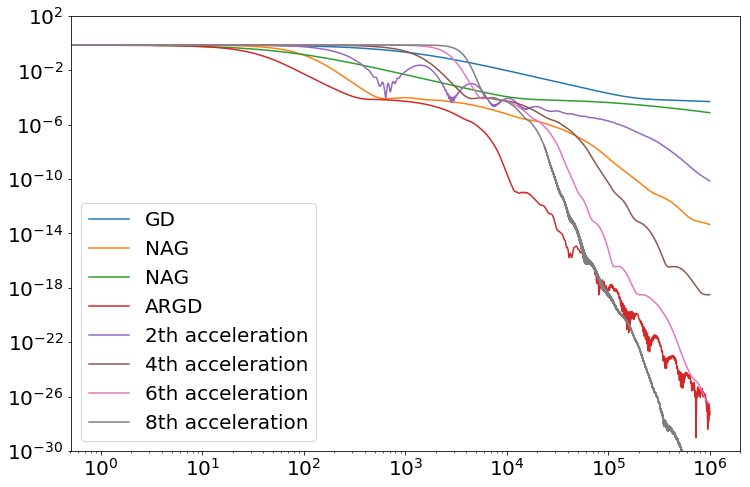

In [320]:
N = int(1e6)
truncate = 0
period = 1
pvalues = [1,2,4]
nrange = period * np.arange(int(N/period))- period + 1

svals = [2, 2, 2, 2]
pvals = [2, 4, 6, 8]
steps = [1e-4, 1e-4, 1e-4, 1e-4]
plt.figure(figsize = (12, 8))
loss_matrix = np.zeros((len(svals)+4, len(nrange)))

f = lambda x: loss_logistic(simulated_separableish_features, simulated_labels, x)
df = lambda x: grad_logistic(simulated_separableish_features, simulated_labels, x)

## gradient descent
weights = np.zeros(dim)
_, losses = gd(f, df, num_steps = N, learning_rate = 1e-6, 
                     inits=weights, period=period)
loss_matrix[0] = losses
plt.loglog(nrange, losses[truncate:], label='GD')

## accelerated gradient descent 
weights = np.zeros(dim)
_, losses = nag(f, df, num_steps = N, learning_rate = 1e-6, 
                     inits=weights, period=period)
plt.loglog(nrange, losses[truncate:], label='NAG')
loss_matrix[1] = losses

## RGD 
weights = np.zeros(dim)
_, losses = rgd(f, df, num_steps = N, learning_rate = 1.5e-5, 
                     inits=weights, period=period)
plt.loglog(nrange, losses[truncate:], label='NAG')
loss_matrix[2] = losses

## ARGD
weights = np.zeros(dim)
weights, losses = argd(f, df, num_steps = N, learning_rate = 1e-5, 
                     inits=weights, period=period)
plt.loglog(nrange, losses[truncate:], label='ARGD')
loss_matrix[3] = losses

for i, s in enumerate(svals):
    losses = simulate(pvals[i], s, N, period, steps[i], np.zeros(dim * 2))
    loss_matrix[i+4] = losses
    plt.loglog(nrange, losses[truncate:], label=str(pvals[i]) + 'th acceleration')
plt.legend()
plt.ylim(1e-30, 100)
plt.rcParams.update({'font.size': 20})


In [321]:
sp.io.savemat('4thorder.mat', {'loss_matrix': loss_matrix})

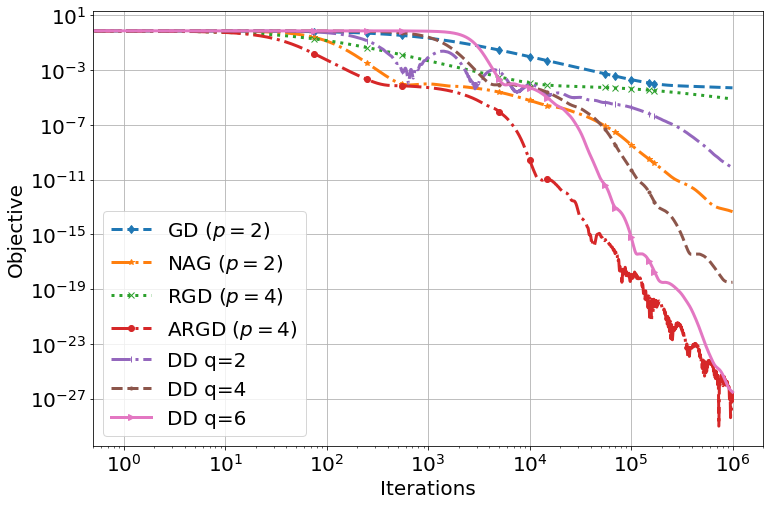

In [322]:
#PLOT EXPERIMENTS
plt.figure(figsize = (12, 8))
plt.loglog(nrange, loss_matrix[0], label='GD ($p=2$)', marker = 'd',markevery = [75,250,550,5000,10000,15000,55000,70000,100000,150000,170000],linestyle = 'dashed',linewidth=3)
plt.loglog(nrange, loss_matrix[1], label='NAG ($p=2$)', marker = '*',markevery = [75,250,550,5000,10000,15000,55000,70000,100000,150000,170000],linestyle = '-.',linewidth=3)
plt.loglog(nrange, loss_matrix[2], label='RGD ($p=4$)', marker = 'x',markevery = [75,250,550,5000,10000,15000,55000,70000,100000,150000,170000], linestyle = ':',linewidth=3)
plt.loglog(nrange, loss_matrix[3], label='ARGD ($p=4$)', marker = 'o',markevery = [75,250,550,5000,10000,15000,100000],linestyle = '-.',linewidth=3)


#for i, s in enumerate(svals):
plt.loglog(nrange, loss_matrix[4], label='DD q=2', marker = '|',markevery = [75,250,550,5000,10000,15000,55000,70000,100000,150000,170000],linestyle = '-.',linewidth=3)
plt.loglog(nrange, loss_matrix[5], label='DD q=4', marker = '.',markevery = [75,250,550,5000,10000,15000,55000,70000,100000,150000,170000],linestyle = 'dashed',linewidth=3)
plt.loglog(nrange, loss_matrix[6], label='DD q=6', marker = '>',markevery = [75,250,550,5000,10000,15000,55000,70000,100000,150000,170000],linewidth=3)


plt.legend()
plt.grid()
plt.xlabel('Iterations')
plt.ylabel('Objective')
plt.rcParams.update({'font.size': 20})

In [301]:
### GRADIENT EVALUATION COMPARISON

(500000,)
[     1      2      3 ... 499998 499999 500000]


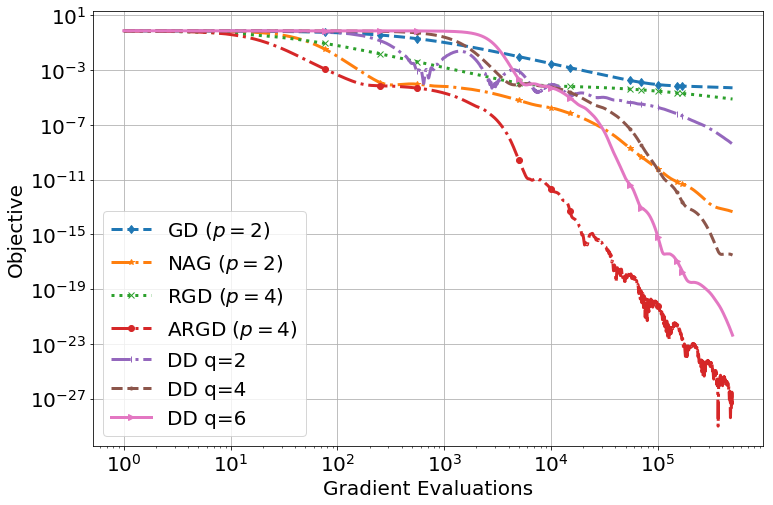

In [323]:
new_loss_matrix = np.zeros((len(svals)+3, len(nrange)/2))
for j in range(4):
    new_loss_matrix[j+3,:] = loss_matrix[j+3,0:len(nrange)/2]
for j in range(4):
    for i in range(len(nrange)/2):
        new_loss_matrix[j,i] = loss_matrix[j,2*i]

print((new_loss_matrix[0]).shape)
print(nrange[1:len(nrange)/2+1])
n = nrange[1:len(nrange)/2+1]
#plot_range = np.linspace(0,1e6,1000)
plt.figure(figsize = (12, 8))
plt.loglog(n, new_loss_matrix[0], label='GD ($p=2$)', marker = 'd',markevery = [75,250,550,5000,10000,15000,55000,70000,100000,150000,170000],linestyle = 'dashed',linewidth=3)
plt.loglog(n, new_loss_matrix[1], label='NAG ($p=2$)', marker = '*',markevery = [75,250,550,5000,10000,15000,55000,70000,100000,150000,170000],linestyle = '-.',linewidth=3)
plt.loglog(n, new_loss_matrix[2], label='RGD ($p=4$)', marker = 'x',markevery = [75,250,550,5000,10000,15000,55000,70000,100000,150000,170000], linestyle = ':',linewidth=3)
plt.loglog(n, new_loss_matrix[3], label='ARGD ($p=4$)', marker = 'o',markevery = [75,250,550,5000,10000,15000,100000],linestyle = '-.',linewidth=3)


#for i, s in enumerate(svals):
plt.loglog(n, new_loss_matrix[4], label='DD q=2', marker = '|',markevery = [75,250,550,5000,10000,15000,55000,70000,100000,150000,170000],linestyle = '-.',linewidth=3)
plt.loglog(n, new_loss_matrix[5], label='DD q=4', marker = '.',markevery = [75,250,550,5000,10000,15000,55000,70000,100000,150000,170000],linestyle = 'dashed',linewidth=3)
plt.loglog(n, new_loss_matrix[6], label='DD q=6', marker = '>',markevery = [75,250,550,5000,10000,15000,55000,70000,100000,150000,170000],linewidth=3)


plt.legend()
plt.grid()
plt.xlabel('Gradient Evaluations')
plt.ylabel('Objective')
plt.rcParams.update({'font.size': 20})